# Threshold Analysis: Delta vs SIRS Proportions

This notebook visualizes the relationship between the delta parameter (recovered duration) and the average proportions of Susceptible, Infected, and Recovered fish at equilibrium.

In [17]:
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

## Replicate Infection Probability Regression

In equation **S3** the authors give the probability that an individual $i$ startles given that individual $j$ has startled. I substitute their $\beta_n$ for $\alpha_n$ for clarity against SIRS.

$$
P(s_i | s_j) = \dfrac{1}{1+e^{-\alpha_1-\alpha_2 LMD - \alpha_3 RAA}}
$$

- *LMD* is the log of the metric distance between the two fish
- *RAA* is the ranked angular area of fish $j$ (compared to other fish) on the retina of fish $i$.

Authors fit a logistic regression model to the entire dataset and find coefficients
- $\alpha_1=0.06449$
- $\alpha_2=−3.20552$
- $\alpha_3=−0.08016$.

I will try to replicate this regression.

In [18]:
# Read the CSV into dataframe
csv_path = "realdata/first_responders_srk1.csv"
df = pd.read_csv(csv_path)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14490 entries, 0 to 14489
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Trial             14490 non-null  object 
 1   Event_raw         14490 non-null  int64  
 2   Event_trial       14490 non-null  int64  
 3   Response          14490 non-null  int64  
 4   Resp_Int          14490 non-null  float64
 5   Initiator         14490 non-null  float64
 6   Log_Init          14490 non-null  float64
 7   When              14490 non-null  object 
 8   Class             14490 non-null  object 
 9   Dist_metric       14490 non-null  float64
 10  Log_dist_metric   14490 non-null  float64
 11  Dist_topological  14490 non-null  int64  
 12  Ang_area          14490 non-null  float64
 13  Rank_area         14490 non-null  int64  
 14  Loom              14490 non-null  float64
 15  Log_loom          14490 non-null  float64
 16  Ang_pos           14490 non-null  float6

This code block - written by Claude - attempts to recreate the coefficients the authors find in the last paragraph of Section 6.1.

There is a difference in the author's values compared to what I could find. I think that's due to the simplification of omitting the higher order terms in equation **S7**. But they say that for small cascades they are very small, so this works out.

In [19]:
# Fit the logistic regression model, to verify author's findings
# Targeting the PARAGRAPH values for first exposure (combining Before+After)
# Target: Intercept=0.06449, Log_dist_metric=-3.20552, Rank_area=-0.08016

# Try different data filters to match author's approach
X1 = df[["Log_dist_metric", "Rank_area"]]
y1 = df["Response"]
X1_const = sm.add_constant(X1)

logit1 = sm.Logit(y1, X1_const)
result1 = logit1.fit(disp=0)

# Try filtering for Schreckstoff only
df_schreck = df[df["Class"] == "Schreck"].copy()
X2 = df_schreck[["Log_dist_metric", "Rank_area"]]
y2 = df_schreck["Response"]
X2_const = sm.add_constant(X2)

logit2 = sm.Logit(y2, X2_const)
result2 = logit2.fit(disp=0)

# Try Water control only
df_water = df[df["Class"] == "Water"].copy()
X3 = df_water[["Log_dist_metric", "Rank_area"]]
y3 = df_water["Response"]
X3_const = sm.add_constant(X3)

logit3 = sm.Logit(y3, X3_const)
result3 = logit3.fit(disp=0)

# Try only After Schreckstoff
df_after_schreck = df[(df["When"] == "After") & (df["Class"] == "Schreck")].copy()
X4 = df_after_schreck[["Log_dist_metric", "Rank_area"]]
y4 = df_after_schreck["Response"]
X4_const = sm.add_constant(X4)

logit4 = sm.Logit(y4, X4_const)
result4 = logit4.fit(disp=0)

# Try Before+After Water (baseline)
df_water_both = df[df["Class"] == "Water"].copy()
X5 = df_water_both[["Log_dist_metric", "Rank_area"]]
y5 = df_water_both["Response"]
X5_const = sm.add_constant(X5)

logit5 = sm.Logit(y5, X5_const)
result5 = logit5.fit(disp=0)

# Summary comparison
print("\n" + "=" * 80)
print("SUMMARY COMPARISON")
print("=" * 80)

comparison = pd.DataFrame(
    {
        "Data Filter": [
            "Authors (Paragraph)",
            "All data",
            "Schreck only",
            "Water only",
            "After+Schreck",
            "Water (Before+After)",
        ],
        "Intercept": [
            0.06449,
            result1.params["const"],
            result2.params["const"],
            result3.params["const"],
            result4.params["const"],
            result5.params["const"],
        ],
        "Log_dist_metric": [
            -3.20552,
            result1.params["Log_dist_metric"],
            result2.params["Log_dist_metric"],
            result3.params["Log_dist_metric"],
            result4.params["Log_dist_metric"],
            result5.params["Log_dist_metric"],
        ],
        "Rank_area": [
            -0.08016,
            result1.params["Rank_area"],
            result2.params["Rank_area"],
            result3.params["Rank_area"],
            result4.params["Rank_area"],
            result5.params["Rank_area"],
        ],
    }
)

print("\n", comparison.to_string(index=False))

# Find closest match
diffs = []
for i in range(1, 6):
    diff = (
        abs(comparison.iloc[i]["Intercept"] - 0.06449)
        + abs(comparison.iloc[i]["Log_dist_metric"] - (-3.20552))
        + abs(comparison.iloc[i]["Rank_area"] - (-0.08016))
    )
    diffs.append(diff)

best_idx = diffs.index(min(diffs)) + 1
print(f"\n\nBest match: {comparison.iloc[best_idx]['Data Filter']}")
print(f"Total absolute difference: {min(diffs):.4f}")


SUMMARY COMPARISON

          Data Filter  Intercept  Log_dist_metric  Rank_area
 Authors (Paragraph)   0.064490        -3.205520  -0.080160
            All data  -0.143799        -2.919403  -0.090306
        Schreck only   0.103641        -3.297823  -0.075034
          Water only  -1.163007        -1.688313  -0.142336
       After+Schreck   0.319212        -3.639221  -0.062179
Water (Before+After)  -1.163007        -1.688313  -0.142336


Best match: Schreck only
Total absolute difference: 0.1366


### Parameters I use

According to the logistic regression above, I will use the logistic regression:

$$
P(s_i | s_j) = \dfrac{1}{1+e^{-\alpha_1-\alpha_2 LMD - \alpha_3 RAA}}
$$

- $\alpha_1 = 0.103641$
- $\alpha_2 = -3.297823$
- $\alpha_3 = -0.075034$

This yields the following plot, overlaid with startles from the dataset.

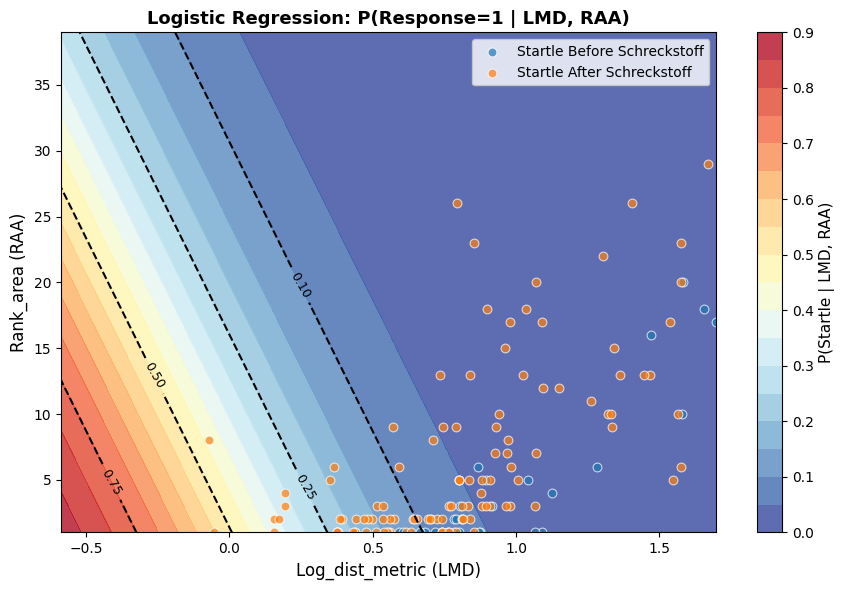

In [20]:
# Plot learned logistic regression for LMD and RAA

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Use the Schreck-only dataset (the selected model)
df_plot = df_schreck.copy()

# Create a mesh grid over the feature space
log_dist_range = np.linspace(
    df_plot["Log_dist_metric"].min(), df_plot["Log_dist_metric"].max(), 100
)
rank_area_range = np.linspace(
    df_plot["Rank_area"].min(), df_plot["Rank_area"].max(), 100
)
log_dist_mesh, rank_area_mesh = np.meshgrid(log_dist_range, rank_area_range)

# Get the fitted coefficients from result2 (Schreck only)
beta_1 = result2.params["const"]
beta_2 = result2.params["Log_dist_metric"]
beta_3 = result2.params["Rank_area"]

# Calculate probability surface: P = 1 / (1 + exp(-beta_1 - beta_2*LMD - beta_3*RAA))
logit = beta_1 + beta_2 * log_dist_mesh + beta_3 * rank_area_mesh
prob_mesh = 1 / (1 + np.exp(-logit))

fig2, ax2 = plt.subplots(figsize=(9, 6))

# Create contour plot
contour = ax2.contourf(
    log_dist_mesh, rank_area_mesh, prob_mesh, levels=20, cmap="RdYlBu_r", alpha=0.8
)
contour_lines = ax2.contour(
    log_dist_mesh,
    rank_area_mesh,
    prob_mesh,
    levels=[0.1, 0.25, 0.5, 0.75, 0.9],
    colors="black",
    linewidths=1.5,
    linestyles="--",
)
ax2.clabel(contour_lines, inline=True, fontsize=9, fmt="%.2f")

# Separate Response=1 (rare) and Response=0 (common)
df_response1 = df_plot[df_plot["Response"] == 1]
df_response0 = df_plot[df_plot["Response"] == 0]
# Overlay actual Response=1 data points
response1_before = df_response1[df_response1["When"] == "Before"]
response1_after = df_response1[df_response1["When"] == "After"]
ax2.scatter(
    response1_before["Log_dist_metric"],
    response1_before["Rank_area"],
    marker="o",
    s=40,
    alpha=0.7,
    edgecolors="white",
    linewidths=0.8,
    label="Startle Before Schreckstoff",
)
ax2.scatter(
    response1_after["Log_dist_metric"],
    response1_after["Rank_area"],
    marker="o",
    s=40,
    alpha=0.7,
    edgecolors="white",
    linewidths=0.8,
    label="Startle After Schreckstoff",
)

ax2.set_xlabel("Log_dist_metric (LMD)", fontsize=12)
ax2.set_ylabel("Rank_area (RAA)", fontsize=12)
ax2.set_title(
    "Logistic Regression: P(Response=1 | LMD, RAA)", fontsize=13, fontweight="bold"
)
ax2.legend(loc="best")

# Add colorbar
cbar = plt.colorbar(contour, ax=ax2)
cbar.set_label("P(Startle | LMD, RAA)", fontsize=11)

plt.tight_layout()
plt.show()

## Empirical Nearest Neighbor Distances: Scared vs Relaxed States to Inform Couzin Model

The `NND_data.h5` file contains nearest neighbor distance measurements for fish under two conditions:
- **Schreck (scared)**: Fish exposed to schreckstoff (alarm hormone) - tight formation
- **Water (relaxed)**: Water control - loose formation

These measurements inform the Couzin model zone parameters for simulating scared vs relaxed schooling behavior.

I take the median nearest neighbor distance across 500 frames after the injection of water or Schreckstoff into the tank.

In [21]:
# Load empirical nearest neighbor distance (NND) data
with h5py.File("realdata/NND_data.h5", "r") as f:
    schreck_data = f["schreck_1st"][:]  # Schreckstoff (alarm hormone) - scared state
    water_data = f["water_1st"][:]  # Water control - relaxed state

# Replace any zero with NaN
schreck_nnd = np.where(schreck_data == 0, np.nan, schreck_data)
water_nnd = np.where(water_data == 0, np.nan, water_data)

# Get median distance of all fish in all frames of all trials, ignoring NaN
schreck_median_nnd = np.nanmedian(schreck_nnd[2000:2500, :, :])
water_median_nnd = np.nanmedian(water_nnd[2000:2500, :, :])
print(f"Median Schreckstoff nearest neighbor distance: {schreck_median_nnd:.2f} cm")
print(f"Median water nearest neighbor distance: {water_median_nnd:.2f} cm")

print(f"\nComparison:")
print(f"  Ratio (relaxed/scared): {water_median_nnd/schreck_median_nnd:.2f}x")
print(f"  Scared fish swim {(1 - schreck_median_nnd/water_median_nnd)*100:.1f}% closer")
print(
    f"  Relaxed fish swim {(water_median_nnd/schreck_median_nnd - 1)*100:.1f}% farther apart"
)

Median Schreckstoff nearest neighbor distance: 3.54 cm
Median water nearest neighbor distance: 6.01 cm

Comparison:
  Ratio (relaxed/scared): 1.70x
  Scared fish swim 41.2% closer
  Relaxed fish swim 70.0% farther apart


For my simulation I will calibrate Couzin parameters on the relaxed state, and then carry all but attraction into the alarmed state.

I will approximate 5.5 cm average fish body length as a 3 cm diameter sphere.

If relaxed in water:

```python
zone_repulsion = 6.0    # From empirical data
zone_orientation = 24   # Distance for alignment (4× repulsion)
zone_attraction = 48    # Distance for attraction (8× repulsion)
```

And for alarmed by Schreckstoff

```python
zone_repulsion = 3.5    # From empirical data
```

## Load Summary Data

In [22]:
# Read the summary CSV (has multi-level columns)
summary = pd.read_csv("threshold_summary.csv", header=[0, 1], index_col=0)
summary.head()

S_count         I_count         R_count        S_proportion         \
         mean     std    mean     std    mean    std         mean    std   
delta                                                                      
0.1     19.56  12.231   18.24  11.028    2.20  1.841        0.489  0.306   
0.2     18.90  12.474   18.96  11.252    2.14  2.213        0.472  0.312   
0.3     19.46  12.134   18.70  11.061    1.84  1.490        0.486  0.303   
0.4     16.54  11.214   21.20  10.120    2.26  1.805        0.414  0.280   
0.5     20.28  12.347   18.06  11.313    1.66  1.586        0.507  0.309   

      I_proportion        R_proportion         
              mean    std         mean    std  
delta                                          
0.1          0.456  0.276        0.055  0.046  
0.2          0.474  0.281        0.054  0.055  
0.3          0.468  0.277        0.046  0.037  
0.4          0.530  0.253        0.056  0.045  
0.5          0.452  0.283        0.042  0.040

In [23]:
# Extract delta values (from index)
delta_values = summary.index.values

# Extract mean proportions for S, I, R
s_mean = summary[("S_proportion", "mean")].values
i_mean = summary[("I_proportion", "mean")].values
r_mean = summary[("R_proportion", "mean")].values

# Extract std for error bars (optional)
s_std = summary[("S_proportion", "std")].values
i_std = summary[("I_proportion", "std")].values
r_std = summary[("R_proportion", "std")].values

## Bifurcation Analysis: Endemic vs Disease-Free Equilibrium

The key question: **What is the probability that the system settles into an endemic equilibrium (I > 0) vs a disease-free equilibrium (I ≈ 0)?**

Averaging across trials with different outcomes masks this bimodal behavior.

In [24]:
# Load detailed trial-by-trial results
detailed = pd.read_csv("threshold_detailed_results-shreck.csv")
print(f"Loaded {len(detailed)} trial results")
print(f"Delta values: {detailed['delta'].nunique()} unique values")
print(f"Trials per delta: {len(detailed) // detailed['delta'].nunique()}")
detailed.head()

Loaded 10500 trial results
Delta values: 21 unique values
Trials per delta: 500


,delta,trial,S_count,I_count,R_count,S_proportion,I_proportion,R_proportion
0,0.0,0,7,30,3,0.175,0.750,0.075
1,0.0,1,40,0,0,1.000,0.000,0.000
2,0.0,2,9,26,5,0.225,0.650,0.125
3,0.0,3,40,0,0,1.000,0.000,0.000
4,0.0,4,11,27,2,0.275,0.675,0.050


In [25]:
# Define threshold for endemic equilibrium (I > 1% means disease persists)
ENDEMIC_THRESHOLD = 0.01

# Calculate probability of endemic equilibrium for each delta
endemic_prob_series = detailed.groupby("delta", observed=False).apply(
    lambda x: (x["I_proportion"] > ENDEMIC_THRESHOLD).sum() / len(x),
    include_groups=False,
)

# Extract delta values and probabilities in matching order
delta_values_bifurcation = endemic_prob_series.index.values
endemic_probs = endemic_prob_series.values

# Probability of disease-free equilibrium
disease_free_probs = 1 - endemic_probs

print(
    f"Endemic probability range: {endemic_probs.min():.2%} to {endemic_probs.max():.2%}"
)
print(
    f"Disease-free probability range: {disease_free_probs.min():.2%} to {disease_free_probs.max():.2%}"
)
print(
    f"\nDelta values for bifurcation analysis: {len(delta_values_bifurcation)} points"
)

Endemic probability range: 0.00% to 84.20%
Disease-free probability range: 15.80% to 100.00%

Delta values for bifurcation analysis: 21 points


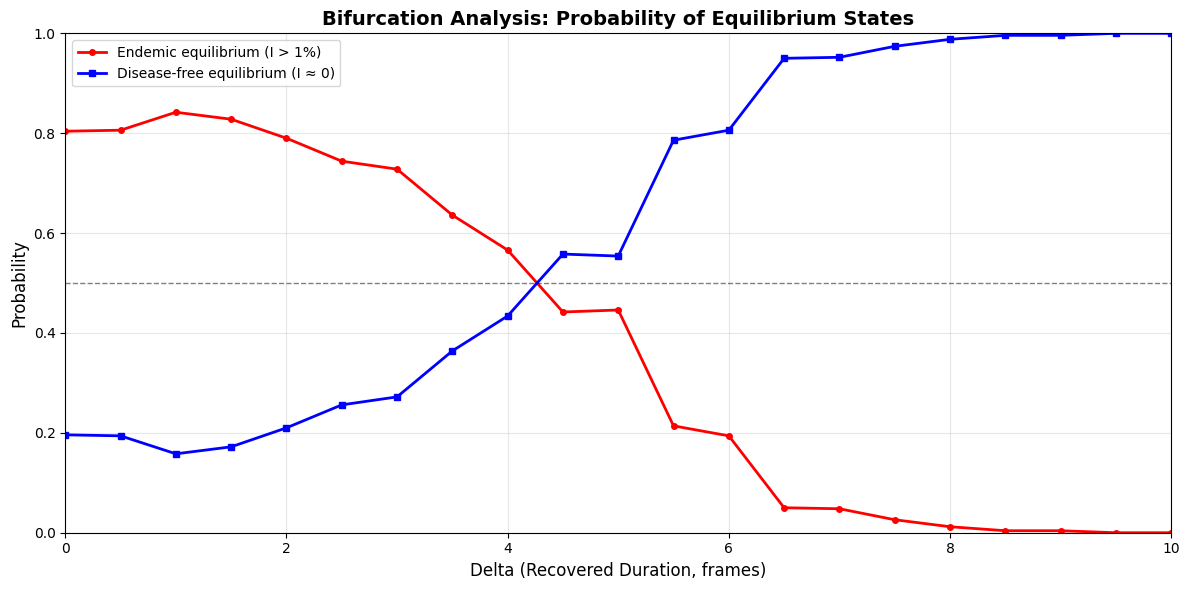

Plot saved to: threshold_bifurcation.png


In [26]:
# Create bifurcation plot
plt.figure(figsize=(12, 6))

# Plot probability of each outcome
plt.plot(
    delta_values_bifurcation,
    endemic_probs,
    "r-",
    linewidth=2,
    marker="o",
    markersize=4,
    label="Endemic equilibrium (I > 1%)",
)
plt.plot(
    delta_values_bifurcation,
    disease_free_probs,
    "b-",
    linewidth=2,
    marker="s",
    markersize=4,
    label="Disease-free equilibrium (I ≈ 0)",
)

# Formatting
plt.xlabel("Delta (Recovered Duration, frames)", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.title(
    "Bifurcation Analysis: Probability of Equilibrium States",
    fontsize=14,
    fontweight="bold",
)
plt.legend(fontsize=10, loc="best")
plt.grid(True, alpha=0.3)
plt.xlim(delta_values_bifurcation[0], delta_values_bifurcation[-1])
plt.ylim(0, 1)

# Add horizontal line at 50% for reference
plt.axhline(y=0.5, color="k", linestyle="--", linewidth=1, alpha=0.5)

plt.tight_layout()
plt.savefig("threshold_bifurcation.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"Plot saved to: threshold_bifurcation.png")

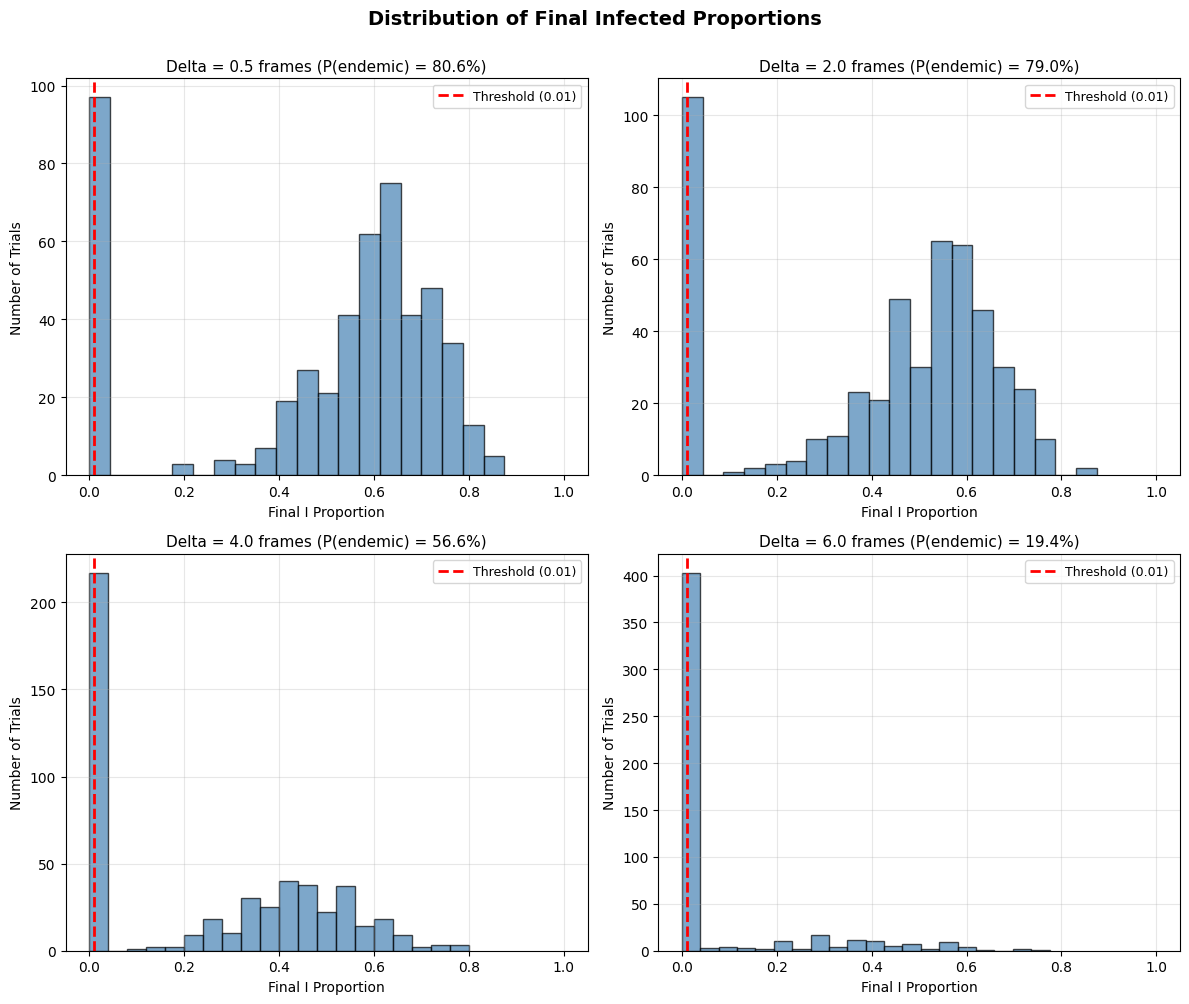

Plot saved to: threshold_distributions.png


In [27]:
# Distribution analysis: Show histograms for selected delta values
key_deltas_dist = [0.5, 2.0, 4.0, 6.0]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, delta in enumerate(key_deltas_dist):
    ax = axes[i]
    data = detailed[detailed["delta"] == delta]["I_proportion"]

    # Calculate statistics
    n_endemic = (data > ENDEMIC_THRESHOLD).sum()
    n_total = len(data)
    p_endemic = n_endemic / n_total

    ax.hist(data, bins=20, edgecolor="black", alpha=0.7, color="steelblue")
    ax.axvline(
        ENDEMIC_THRESHOLD,
        color="r",
        linestyle="--",
        linewidth=2,
        label=f"Threshold ({ENDEMIC_THRESHOLD})",
    )
    ax.set_xlabel("Final I Proportion", fontsize=10)
    ax.set_ylabel("Number of Trials", fontsize=10)
    ax.set_title(
        f"Delta = {delta:.1f} frames (P(endemic) = {p_endemic:.1%})", fontsize=11
    )
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-0.05, 1.05)

plt.suptitle(
    "Distribution of Final Infected Proportions", fontsize=14, fontweight="bold", y=1.00
)
plt.tight_layout()
plt.savefig("threshold_distributions.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"Plot saved to: threshold_distributions.png")

In [28]:
# Find critical delta where P(endemic) crosses 50%
crossing_indices = np.where(np.diff(np.sign(endemic_probs - 0.5)))[0]

if len(crossing_indices) > 0:
    idx = crossing_indices[0]
    critical_delta_lower = delta_values_bifurcation[idx]
    critical_delta_upper = delta_values_bifurcation[idx + 1]

    print("=" * 60)
    print("CRITICAL DELTA THRESHOLD ANALYSIS")
    print("=" * 60)
    print(f"\nTransition from endemic to disease-free occurs between:")
    print(
        f"  Delta = {critical_delta_lower:.2f}: P(endemic) = {endemic_probs[idx]:.1%}"
    )
    print(
        f"  Delta = {critical_delta_upper:.2f}: P(endemic) = {endemic_probs[idx+1]:.1%}"
    )

    # Linear interpolation to estimate 50% crossing point
    if endemic_probs[idx] != endemic_probs[idx + 1]:
        critical_delta_est = critical_delta_lower + (0.5 - endemic_probs[idx]) * (
            critical_delta_upper - critical_delta_lower
        ) / (endemic_probs[idx + 1] - endemic_probs[idx])
        print(f"\nEstimated 50% threshold: Delta ≈ {critical_delta_est:.2f} frames")

    # Show a few delta values around the transition
    print(f"\nProbabilities around transition:")
    for i in range(max(0, idx - 2), min(len(delta_values_bifurcation), idx + 4)):
        print(
            f"  Delta = {delta_values_bifurcation[i]:5.1f}: P(endemic) = {endemic_probs[i]:5.1%}, "
            f"P(disease-free) = {disease_free_probs[i]:5.1%}"
        )
else:
    print("No 50% crossing point found in this delta range")
    print(
        f"P(endemic) ranges from {endemic_probs.min():.1%} to {endemic_probs.max():.1%}"
    )

CRITICAL DELTA THRESHOLD ANALYSIS

Transition from endemic to disease-free occurs between:
  Delta = 4.00: P(endemic) = 56.6%
  Delta = 4.50: P(endemic) = 44.2%

Estimated 50% threshold: Delta ≈ 4.27 frames

Probabilities around transition:
  Delta =   3.0: P(endemic) = 72.8%, P(disease-free) = 27.2%
  Delta =   3.5: P(endemic) = 63.6%, P(disease-free) = 36.4%
  Delta =   4.0: P(endemic) = 56.6%, P(disease-free) = 43.4%
  Delta =   4.5: P(endemic) = 44.2%, P(disease-free) = 55.8%
  Delta =   5.0: P(endemic) = 44.6%, P(disease-free) = 55.4%
  Delta =   5.5: P(endemic) = 21.4%, P(disease-free) = 78.6%


## Plot Delta vs SIRS Proportions

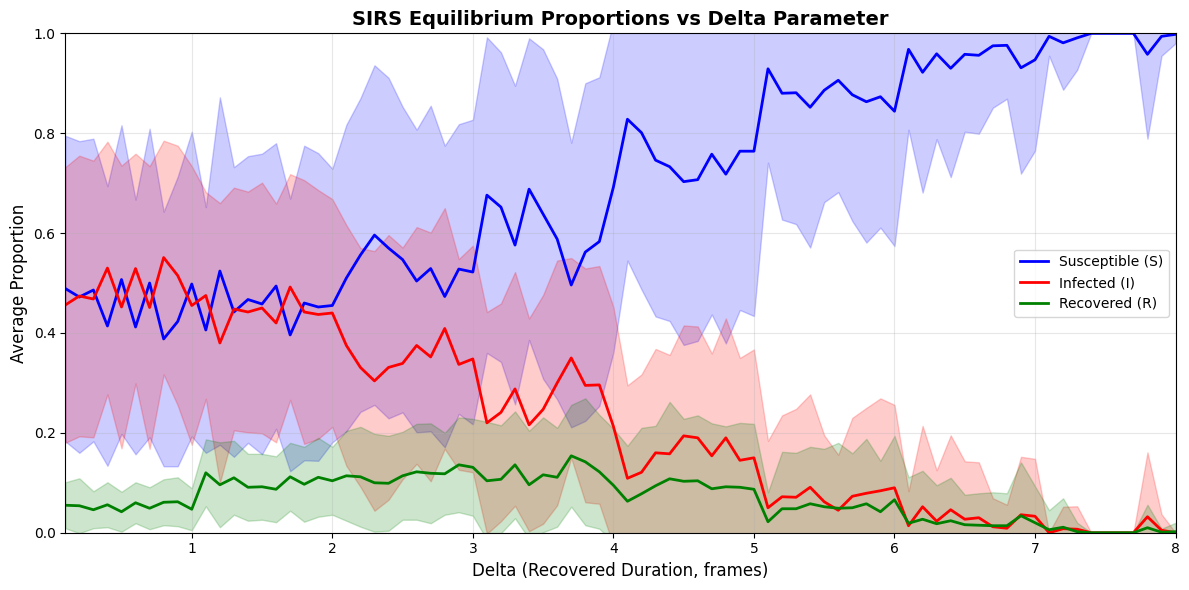

Plot saved to: threshold_delta_vs_sir.png


In [29]:
# Create the plot
plt.figure(figsize=(12, 6))

# Plot mean proportions
plt.plot(delta_values, s_mean, "b-", label="Susceptible (S)", linewidth=2)
plt.plot(delta_values, i_mean, "r-", label="Infected (I)", linewidth=2)
plt.plot(delta_values, r_mean, "g-", label="Recovered (R)", linewidth=2)

# Add shaded regions for standard deviation (optional)
plt.fill_between(delta_values, s_mean - s_std, s_mean + s_std, color="blue", alpha=0.2)
plt.fill_between(delta_values, i_mean - i_std, i_mean + i_std, color="red", alpha=0.2)
plt.fill_between(delta_values, r_mean - r_std, r_mean + r_std, color="green", alpha=0.2)

# Labels and formatting
plt.xlabel("Delta (Recovered Duration, frames)", fontsize=12)
plt.ylabel("Average Proportion", fontsize=12)
plt.title(
    "SIRS Equilibrium Proportions vs Delta Parameter", fontsize=14, fontweight="bold"
)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim(delta_values[0], delta_values[-1])
plt.ylim(0, 1)

plt.tight_layout()
plt.savefig("threshold_delta_vs_sir.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"Plot saved to: threshold_delta_vs_sir.png")

## Focus on Infected Proportion

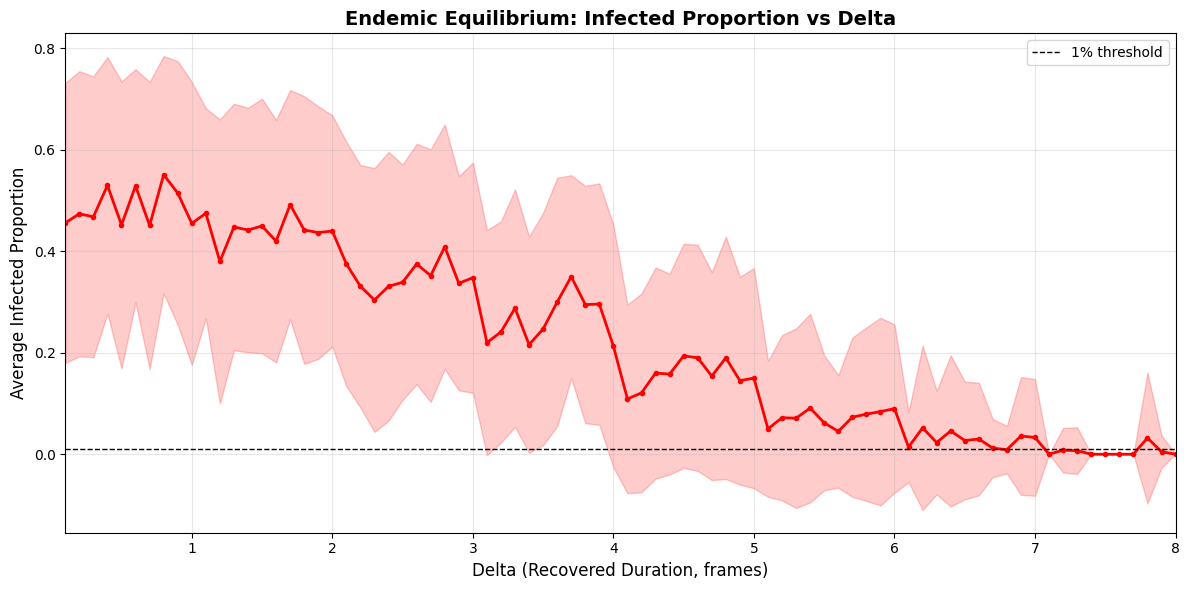

Plot saved to: threshold_infected_vs_delta.png


In [30]:
# Zoom in on infected proportion to identify threshold
plt.figure(figsize=(12, 6))

plt.plot(delta_values, i_mean, "r-", linewidth=2, marker="o", markersize=3)
plt.fill_between(delta_values, i_mean - i_std, i_mean + i_std, color="red", alpha=0.2)

# Add horizontal line at 1% threshold
plt.axhline(y=0.01, color="k", linestyle="--", linewidth=1, label="1% threshold")

plt.xlabel("Delta (Recovered Duration, frames)", fontsize=12)
plt.ylabel("Average Infected Proportion", fontsize=12)
plt.title(
    "Endemic Equilibrium: Infected Proportion vs Delta", fontsize=14, fontweight="bold"
)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim(delta_values[0], delta_values[-1])

plt.tight_layout()
plt.savefig("threshold_infected_vs_delta.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"Plot saved to: threshold_infected_vs_delta.png")

## Find Critical Threshold

In [31]:
# Find the first delta value where I > 1%
endemic_mask = i_mean > 0.01
if endemic_mask.any():
    threshold_delta = delta_values[endemic_mask][0]
    print(f"Critical threshold: delta = {threshold_delta:.2f} frames")
    print(f"At this threshold:")
    idx = np.where(delta_values == threshold_delta)[0][0]
    print(f"  S = {s_mean[idx]:.3f} ± {s_std[idx]:.3f}")
    print(f"  I = {i_mean[idx]:.3f} ± {i_std[idx]:.3f}")
    print(f"  R = {r_mean[idx]:.3f} ± {r_std[idx]:.3f}")
else:
    print("No endemic equilibrium found in this delta range")

Critical threshold: delta = 0.10 frames
At this threshold:
  S = 0.489 ± 0.306
  I = 0.456 ± 0.276
  R = 0.055 ± 0.046


## Summary Statistics Table

In [32]:
# Show key delta values
key_deltas = [0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
key_deltas = [d for d in key_deltas if d in delta_values]

print("Key Delta Values Summary:")
print("=" * 60)
for delta in key_deltas:
    idx = np.where(delta_values == delta)[0][0]
    print(f"Delta = {delta:.1f}:")
    print(f"  S = {s_mean[idx]:.3f} ± {s_std[idx]:.3f}")
    print(f"  I = {i_mean[idx]:.3f} ± {i_std[idx]:.3f}")
    print(f"  R = {r_mean[idx]:.3f} ± {r_std[idx]:.3f}")
    print()

Key Delta Values Summary:
Delta = 0.1:
  S = 0.489 ± 0.306
  I = 0.456 ± 0.276
  R = 0.055 ± 0.046

Delta = 0.5:
  S = 0.507 ± 0.309
  I = 0.452 ± 0.283
  R = 0.042 ± 0.040

Delta = 1.0:
  S = 0.498 ± 0.305
  I = 0.455 ± 0.279
  R = 0.047 ± 0.042

Delta = 2.0:
  S = 0.455 ± 0.274
  I = 0.440 ± 0.228
  R = 0.104 ± 0.068

Delta = 3.0:
  S = 0.522 ± 0.305
  I = 0.348 ± 0.227
  R = 0.131 ± 0.097

Delta = 4.0:
  S = 0.692 ± 0.331
  I = 0.213 ± 0.239
  R = 0.095 ± 0.113

Delta = 5.0:
  S = 0.764 ± 0.330
  I = 0.150 ± 0.217
  R = 0.087 ± 0.131

Delta = 6.0:
  S = 0.844 ± 0.270
  I = 0.090 ± 0.166
  R = 0.066 ± 0.128

Delta = 7.0:
  S = 0.947 ± 0.182
  I = 0.033 ± 0.115
  R = 0.020 ± 0.073

Delta = 8.0:
  S = 0.998 ± 0.018
  I = 0.000 ± 0.000
  R = 0.002 ± 0.018

